# Project 5B: Flow Matching from Scratch!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.7 MB/s eta 0:00:00


In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from tqdm import tqdm
import torch

## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        temp = self.bn(self.conv(x))
        return self.gelu(temp)
        # ===== end of code ====


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        temp = self.bn(self.conv(x))
        return self.gelu(temp)
        # ===== end of code ====


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        temp = self.bn(self.conv(x))
        return self.gelu(temp)
        # ===== end of code ====


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== your code here! ====
        self.pool = nn.AvgPool2d(kernel_size=7)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.pool(x)
        # ===== end of code ====


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        temp = self.bn(self.conv(x))
        return self.gelu(temp)
        # ===== end of code ====


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.conv2(self.conv1(x))
        # ===== end of code ====


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.convblock(self.downconv(x))
        # ===== end of code ====


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.convblock(self.upconv(x))
        # ===== end of code ====

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====

        D = num_hiddens

        self.conv_in = ConvBlock(in_channels, D)
        self.down1 = DownBlock(D, D)
        self.down2 = DownBlock(D, D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(D)

        self.up1 = UpBlock(D * 2, D)
        self.up2 = UpBlock(D * 2, D)

        self.conv_out = ConvBlock(D * 2, D)

        self.final = nn.Conv2d(D + in_channels, in_channels, kernel_size = 3, stride = 1, padding=1)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====

        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)

        x6 = self.up1(torch.cat([x5, x3], dim = 1))
        x7 = self.up2(torch.cat([x6, x2], dim = 1))
        x8 = self.conv_out(torch.cat([x7, x1], dim = 1))

        out = self.final(torch.cat([x8, x], dim = 1))

        return out

        # ===== end of code ====

# Part 1.2: Using the UNet to Train a Denoiser

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.70MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


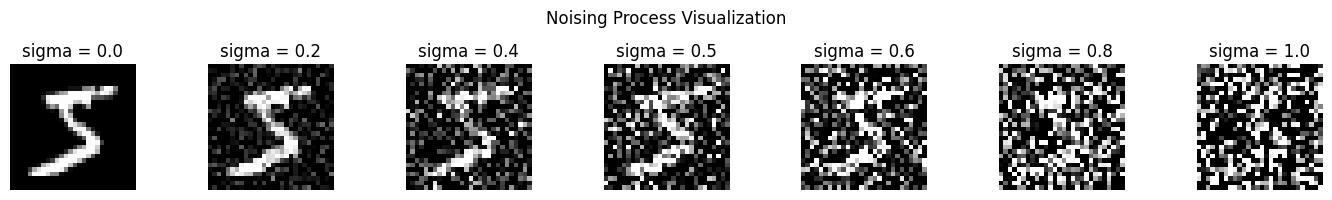

In [ ]:
# Visualize images at different noisy level
# ===== your code here! ====

levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

mnist_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
clean_image, x = mnist_dataset[0]

fig, axes = plt.subplots(1, len(levels), figsize=(14, 2))

for i, sig in enumerate(levels):
    epsilon = torch.randn_like(clean_image)

    temp = clean_image + sig * epsilon
    noisy_image = torch.clamp(temp, 0, 1)

    axes[i].imshow(noisy_image.squeeze(), cmap='gray')
    axes[i].set_title(f'sigma = {sig}')
    axes[i].axis('off')

plt.suptitle('Noising Process Visualization')
plt.tight_layout()
plt.savefig('noising_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====

## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [6]:
device = torch.device('cuda')

# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [7]:
# Define your datasets and dataloaders
# ===== your code here! ====

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle =False)

# ===== end of code ====

In [8]:
# Define your model, optimizer, and loss
# ===== your code here! ====

model = UnconditionalUNet(in_channels = 1, num_hiddens = hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# ===== end of code ====

In [9]:
# The training loops
train_losses = []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        # ===== your code here! ====

        images = images.to(device)

        eps = torch.randn_like(images)
        noisy_images = images + noise_level * eps

        outputs = model(noisy_images)

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

100%|██████████| 235/235 [00:15<00:00, 15.43it/s]


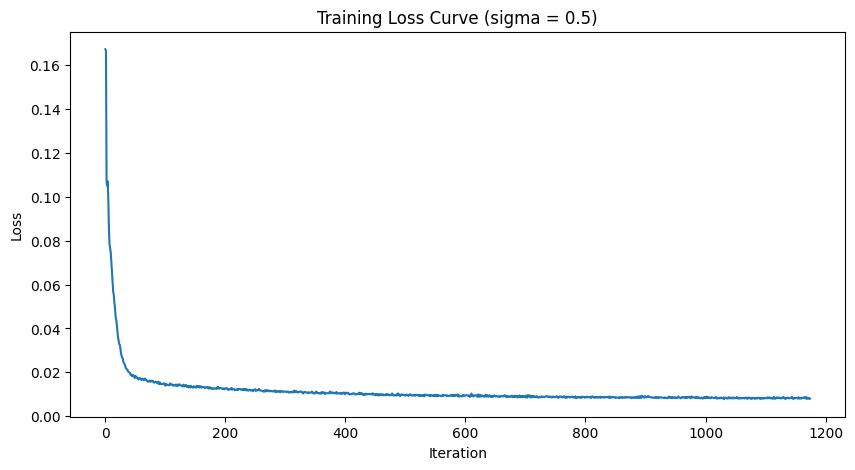

In [10]:
# Visualize your training curve
# ===== your code here! ====

plt.figure(figsize=(10, 5))
plt.plot(train_losses)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Training Loss Curve (sigma = {noise_level})')
plt.savefig('training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()
# ===== end of code ====

## Part 1.2.2: Out-of-Distribution Testing

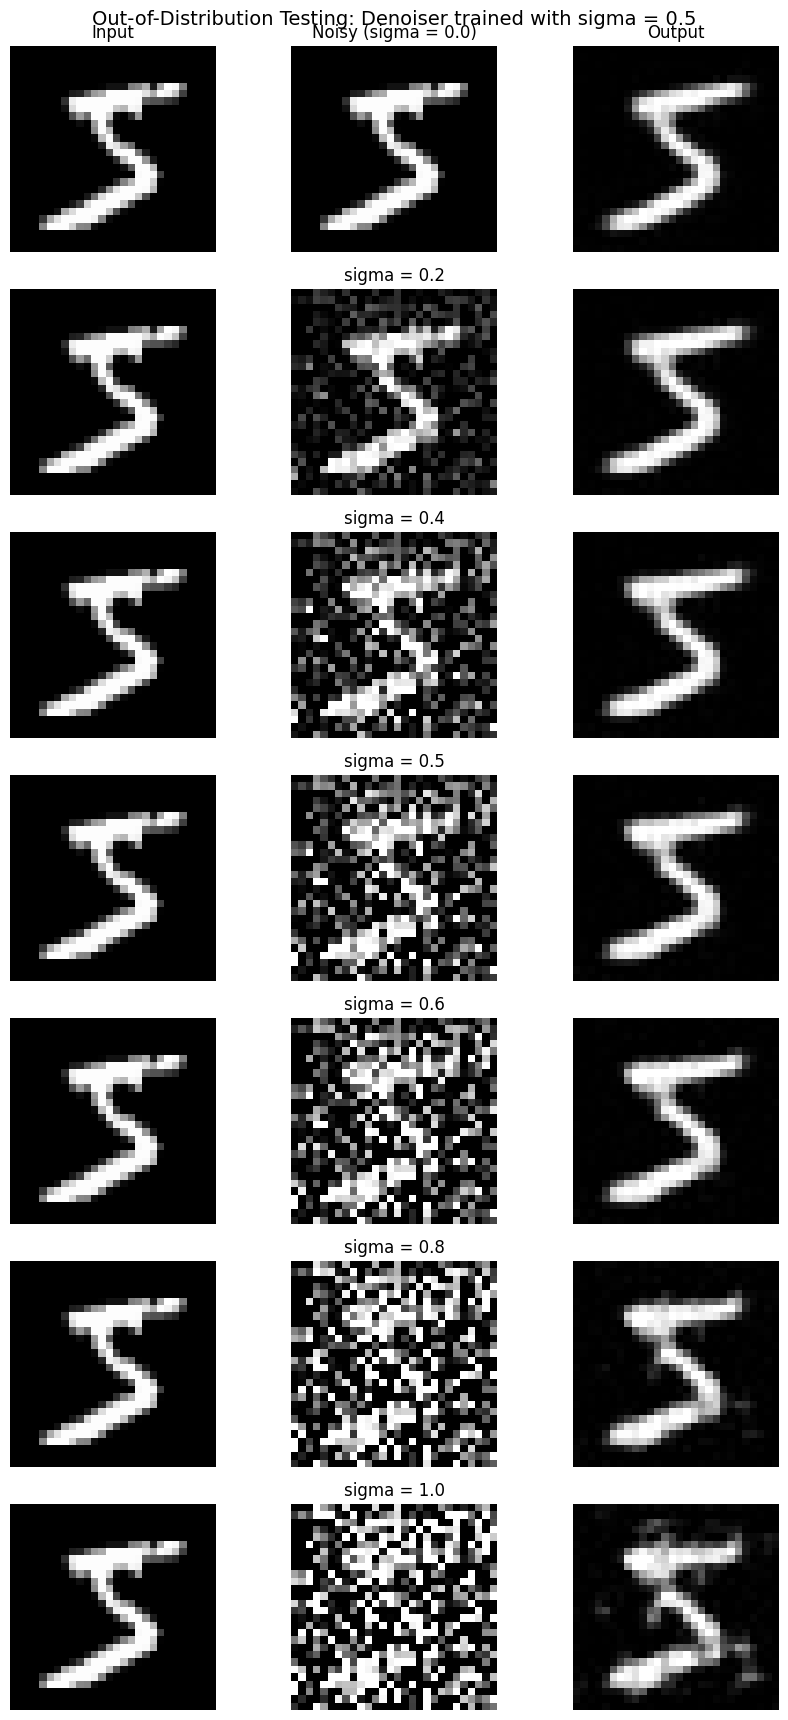

UnconditionalUNet(
  (conv_in): ConvBlock(
    (conv1): Conv(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu): GELU(approximate='none')
    )
    (conv2): Conv(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu): GELU(approximate='none')
    )
  )
  (down1): DownBlock(
    (downconv): DownConv(
      (conv): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (gelu): GELU(approximate='none')
    )
    (convblock): ConvBlock(
      (conv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [11]:
# Visualize OOD testing
# ===== your code here! ====

levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

test_iter = iter(test_loader)
test_images, _ = next(test_iter)
test_image = test_images[0:1].to(device)

model.eval()

fig, axes = plt.subplots(len(levels), 3, figsize=(9, 2.5 * len(levels)))

for i, sig in enumerate(levels):

    torch.manual_seed(37)
    eps = torch.randn_like(test_image)

    noisy_image = test_image + sig * eps

    with torch.no_grad():
        denoised_image = model(noisy_image)

    axes[i, 0].imshow(test_image.cpu().squeeze(), cmap='gray')
    axes[i, 0].set_title('Input' if i == 0 else '')
    axes[i, 0].axis('off')
    axes[i, 0].set_ylabel(f'sigma = {sig}', fontsize=12)

    axes[i, 1].imshow(torch.clamp(noisy_image.cpu().squeeze(), 0, 1), cmap='gray')
    axes[i, 1].set_title(f'Noisy (sigma = {sig})' if i == 0 else f'sigma = {sig}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(torch.clamp(denoised_image.cpu().squeeze(), 0, 1), cmap='gray')
    axes[i, 2].set_title('Output' if i == 0 else '')
    axes[i, 2].axis('off')

plt.suptitle('Out-of-Distribution Testing: Denoiser trained with sigma = 0.5', fontsize=14)
plt.tight_layout()
plt.savefig('ood_testing.png', dpi=150, bbox_inches='tight')
plt.show()

model.train()

# ===== end of code ====

## Part 1.2.3 Denoising Pure Noise

100%|██████████| 235/235 [00:15<00:00, 15.44it/s]



- Results after Epoch 1 -


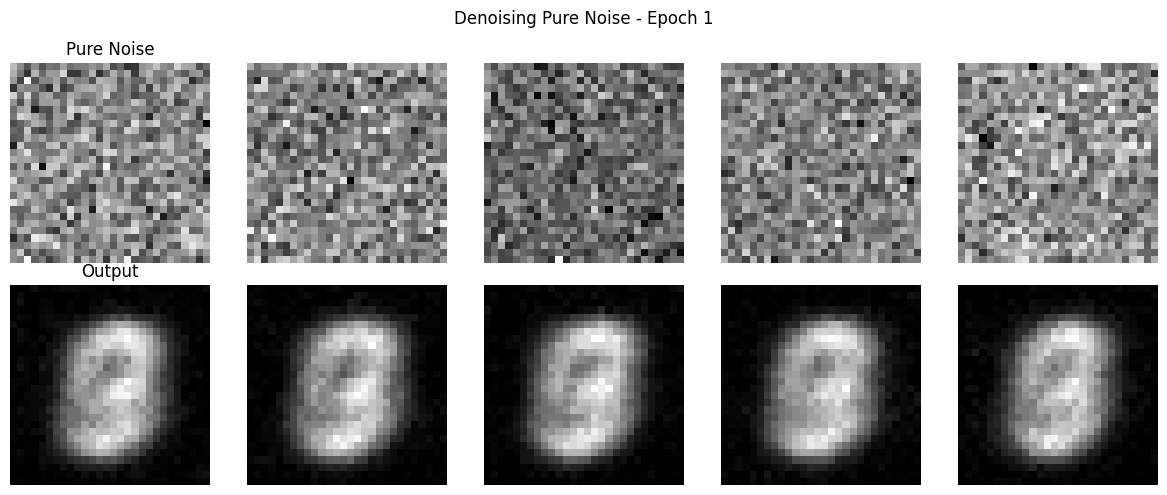

100%|██████████| 235/235 [00:15<00:00, 15.38it/s]



- Results after Epoch 5 -


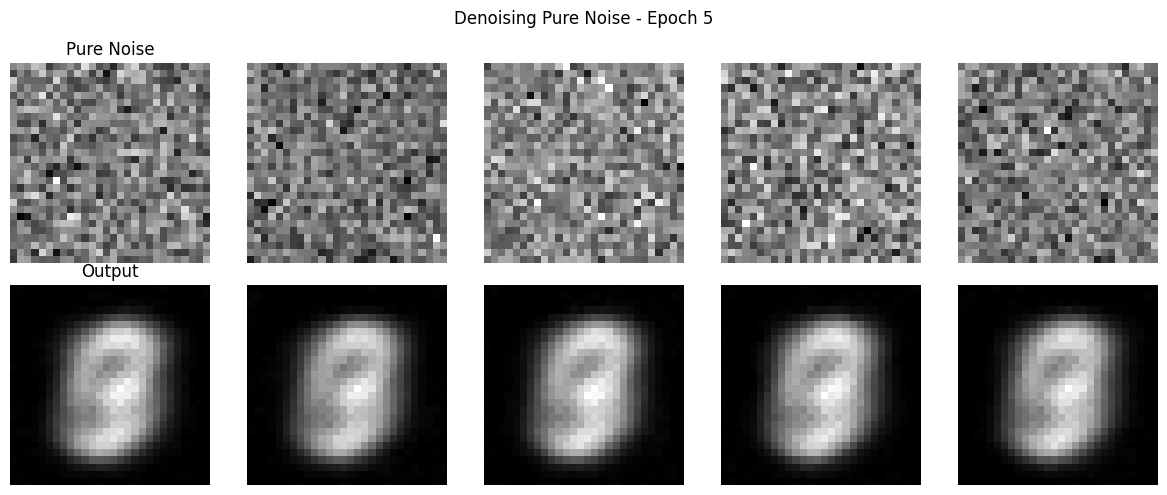

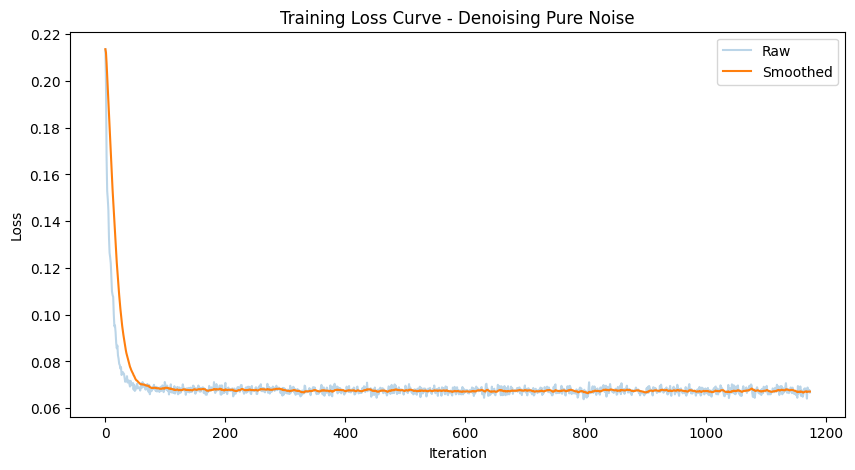

In [ ]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

batch_size = 256
learning_rate = 1e-4
hidden_dim = 128
num_epochs = 5

all_noise = UnconditionalUNet(in_channels = 1, num_hiddens = hidden_dim).to(device)
optimizer_pure_noise = torch.optim.Adam(all_noise.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

train_losses_pure_noise = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)

        noisy_images = torch.randn_like(images)
        outputs = all_noise(noisy_images)

        loss = criterion(outputs, images)
        optimizer_pure_noise.zero_grad()
        loss.backward()
        optimizer_pure_noise.step()

        train_losses_pure_noise.append(loss.item())

    if epoch == 0 or epoch == 4:
        print(f"\n- Results after Epoch {epoch + 1} -")
        all_noise.eval()

        fig, axes = plt.subplots(2, 5, figsize=(12, 5))

        for j in range(5):
            pure_noise = torch.randn(1, 1, 28, 28).to(device)

            with torch.no_grad():
                generated = all_noise(pure_noise)

            axes[0, j].imshow(pure_noise.cpu().squeeze(), cmap='gray')
            axes[0, j].set_title('Pure Noise' if j == 0 else '')
            axes[0, j].axis('off')

            axes[1, j].imshow(torch.clamp(generated.cpu().squeeze(), 0, 1), cmap='gray')
            axes[1, j].set_title('Output' if j == 0 else '')
            axes[1, j].axis('off')

        plt.suptitle(f'Denoising Pure Noise - Epoch {epoch + 1}')
        plt.tight_layout()
        plt.savefig(f'pure_noise_epoch_{epoch + 1}.png', dpi=150, bbox_inches='tight')
        plt.show()

        all_noise.train()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_pure_noise, alpha=0.3, label='Raw')

def smooth(values, weight = 0.9):

    smoothed_versions = []
    last = values[0]
    for v in values:
        temp = 1 - weight
        smoothed_val = last * weight + (temp) * v

        smoothed_versions.append(smoothed_val)
        last = smoothed_val

    return smoothed_versions

plt.plot(smooth(train_losses_pure_noise), label='Smoothed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Denoising Pure Noise')

plt.legend()
plt.savefig('training_loss_pure_noise.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [13]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x
        # ===== end of code ====


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====

        D = num_hiddens

        self.conv_in = ConvBlock(in_channels, D)
        self.down1 = DownBlock(D, D)
        self.down2 = DownBlock(D, D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(D)

        self.up1 = UpBlock(D * 2, D)
        self.up2 = UpBlock(D * 2, D)
        self.conv_out = ConvBlock(D * 2, D)

        self.final = nn.Conv2d(D + in_channels, in_channels, kernel_size = 3, stride = 1, padding = 1)

        self.fc1_t = FCBlock(1, D)
        self.fc2_t = FCBlock(1, D)

        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====

        t = t.view(-1, 1)

        temp_t1 = self.fc1_t(t)
        temp_t2 = self.fc2_t(t)

        t1 = temp_t1.view(temp_t1.shape[0], temp_t1.shape[1], 1, 1)
        t2 = temp_t2.view(temp_t2.shape[0], temp_t2.shape[1], 1, 1)

        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.flatten(x3)

        temp_x5 = self.unflatten(x4)
        x5 = temp_x5 * t1

        temp_x6 = self.up1(torch.cat([x5, x3], dim = 1))
        x6 = temp_x6 * t2

        x7 = self.up2(torch.cat([x6, x2], dim = 1))
        x8 = self.conv_out(torch.cat([x7, x1], dim = 1))

        out = self.final(torch.cat([x8, x], dim = 1))

        return out
        # ===== end of code ====

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [14]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor (clean images).
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====

    curr = x_1.device
    b_size = x_1.shape[0]

    t = torch.rand(b_size, device = curr)

    x = torch.randn_like(x_1)

    t_broadcast = t.view(b_size, 1, 1, 1)
    x_t = (1 - t_broadcast) * x + t_broadcast * x_1

    target = x_1 - x
    pred = unet(x_t, t)

    loss = nn.functional.mse_loss(pred, target)

    return loss

    # ===== end of code ====

In [15]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # ===== your code here! ====

    torch.manual_seed(seed)

    curr = next(unet.parameters()).device
    H, W = img_wh

    x_time = torch.randn(1, 1, H, W, device = curr)

    dt = 1.0 / num_ts

    for i in range(num_ts):

        t = torch.tensor([i / num_ts], device = curr)
        pred = unet(x_time, t)
        x_time = x_time + dt * pred

    return x_time

    # ===== end of code ====

In [16]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

Epoch 1/20: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]


Epoch 1/20, Avg Loss: 0.1561, LR: 0.008913


Epoch 2/20: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Epoch 2/20, Avg Loss: 0.1124, LR: 0.007943


Epoch 3/20: 100%|██████████| 938/938 [00:16<00:00, 56.36it/s]


Epoch 3/20, Avg Loss: 0.1050, LR: 0.007079


Epoch 4/20: 100%|██████████| 938/938 [00:17<00:00, 55.08it/s]


Epoch 4/20, Avg Loss: 0.1010, LR: 0.006310


Epoch 5/20: 100%|██████████| 938/938 [00:16<00:00, 55.37it/s]


Epoch 5/20, Avg Loss: 0.0993, LR: 0.005623


Epoch 6/20: 100%|██████████| 938/938 [00:17<00:00, 55.16it/s]


Epoch 6/20, Avg Loss: 0.0966, LR: 0.005012


Epoch 7/20: 100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 7/20, Avg Loss: 0.0951, LR: 0.004467


Epoch 8/20: 100%|██████████| 938/938 [00:16<00:00, 55.33it/s]


Epoch 8/20, Avg Loss: 0.0942, LR: 0.003981


Epoch 9/20: 100%|██████████| 938/938 [00:16<00:00, 55.42it/s]


Epoch 9/20, Avg Loss: 0.0927, LR: 0.003548


Epoch 10/20: 100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 10/20, Avg Loss: 0.0923, LR: 0.003162


Epoch 11/20: 100%|██████████| 938/938 [00:16<00:00, 55.38it/s]


Epoch 11/20, Avg Loss: 0.0914, LR: 0.002818


Epoch 12/20: 100%|██████████| 938/938 [00:16<00:00, 55.23it/s]


Epoch 12/20, Avg Loss: 0.0909, LR: 0.002512


Epoch 13/20: 100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 13/20, Avg Loss: 0.0905, LR: 0.002239


Epoch 14/20: 100%|██████████| 938/938 [00:16<00:00, 55.38it/s]


Epoch 14/20, Avg Loss: 0.0892, LR: 0.001995


Epoch 15/20: 100%|██████████| 938/938 [00:17<00:00, 54.78it/s]


Epoch 15/20, Avg Loss: 0.0889, LR: 0.001778


Epoch 16/20: 100%|██████████| 938/938 [00:16<00:00, 55.43it/s]


Epoch 16/20, Avg Loss: 0.0886, LR: 0.001585


Epoch 17/20: 100%|██████████| 938/938 [00:16<00:00, 56.23it/s]


Epoch 17/20, Avg Loss: 0.0878, LR: 0.001413


Epoch 18/20: 100%|██████████| 938/938 [00:16<00:00, 55.41it/s]


Epoch 18/20, Avg Loss: 0.0878, LR: 0.001259


Epoch 19/20: 100%|██████████| 938/938 [00:16<00:00, 55.50it/s]


Epoch 19/20, Avg Loss: 0.0874, LR: 0.001122


Epoch 20/20: 100%|██████████| 938/938 [00:16<00:00, 55.36it/s]


Epoch 20/20, Avg Loss: 0.0874, LR: 0.001000


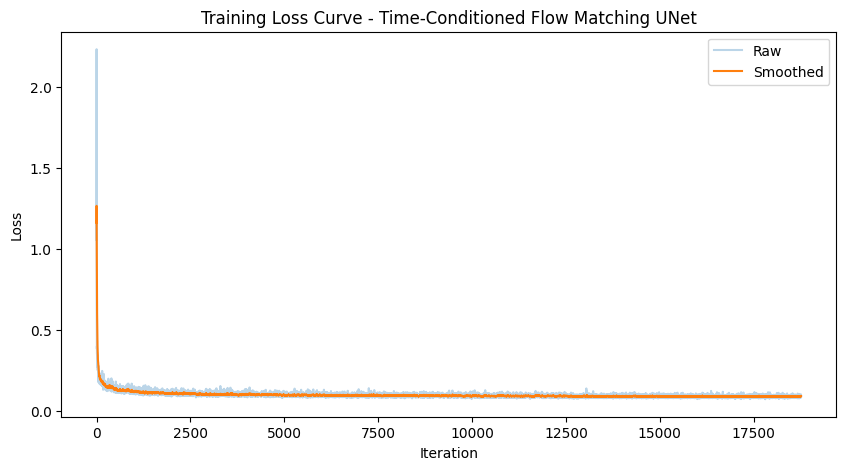

In [17]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 20
num_ts = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle =False)

model = TimeConditionalUNet(in_channels = 1, num_classes = 10, num_hiddens = hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

train_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    for i, (images, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        x_1 = images.to(device)

        loss = time_fm_forward(model, x_1, num_ts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        epoch_losses.append(loss.item())

    scheduler.step()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, alpha=0.3, label='Raw')

def smooth(values, weight=0.9):
    smoothed_version = []
    last = values[0]
    for v in values:
        temp = 1 - weight

        smoothed_val = last * weight + (temp) * v
        smoothed_version.append(smoothed_val)

        last = smoothed_val

    return smoothed_version

plt.plot(smooth(train_losses), label='Smoothed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Time-Conditioned Flow Matching UNet')
plt.legend()
plt.savefig('fm_training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====

# Part 2.3: Sampling from the Time-conditioned UNet

In [18]:
def visualize_samples(model, num_samples = 25, num_ts = 50, seed = 0):
    model.eval()

    images = []

    for i in range(num_samples):
        sample = time_fm_sample(model, img_wh = (28, 28), num_ts = num_ts, seed = seed + i)
        images.append(sample)

    images = torch.cat(images, dim = 0)

    grid_size = int(num_samples ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize = (8, 8))

    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j

            if idx < num_samples:
                img = images[idx].cpu().squeeze()
                img = torch.clamp(img, 0, 1)
                axes[i, j].imshow(img, cmap='gray')

            axes[i, j].axis('off')

    plt.tight_layout()
    return fig

Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 55.34it/s]


Epoch 1/10, Avg Loss: 0.1861

--- Sampling at Epoch 1 ---


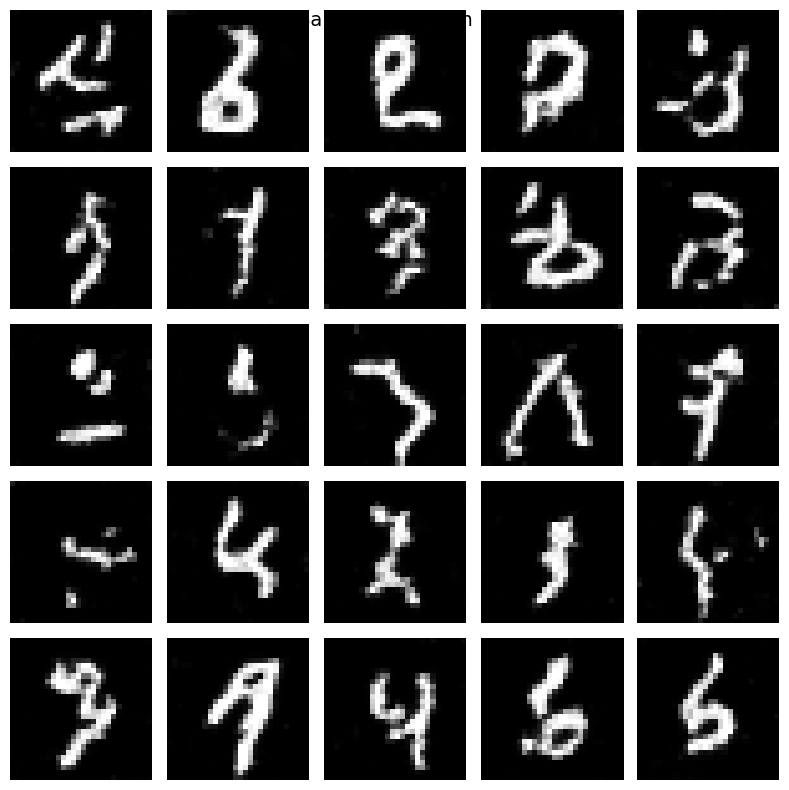

Epoch 2/10: 100%|██████████| 938/938 [00:17<00:00, 54.47it/s]


Epoch 2/10, Avg Loss: 0.1199


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 55.20it/s]


Epoch 3/10, Avg Loss: 0.1091


Epoch 4/10: 100%|██████████| 938/938 [00:17<00:00, 55.13it/s]


Epoch 4/10, Avg Loss: 0.1032


Epoch 5/10: 100%|██████████| 938/938 [00:17<00:00, 55.10it/s]


Epoch 5/10, Avg Loss: 0.0995

--- Sampling at Epoch 5 ---


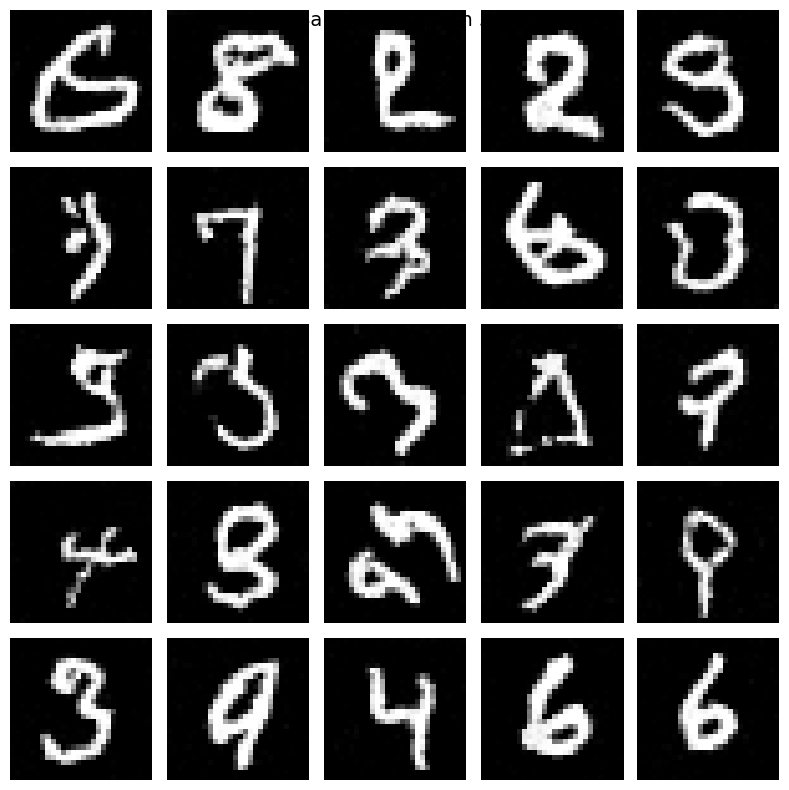

Epoch 6/10: 100%|██████████| 938/938 [00:17<00:00, 54.14it/s]


Epoch 6/10, Avg Loss: 0.0976


Epoch 7/10: 100%|██████████| 938/938 [00:17<00:00, 54.40it/s]


Epoch 7/10, Avg Loss: 0.0954


Epoch 8/10: 100%|██████████| 938/938 [00:17<00:00, 54.34it/s]


Epoch 8/10, Avg Loss: 0.0936


Epoch 9/10: 100%|██████████| 938/938 [00:17<00:00, 54.84it/s]


Epoch 9/10, Avg Loss: 0.0923


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.64it/s]


Epoch 10/10, Avg Loss: 0.0919

--- Sampling at Epoch 10 ---


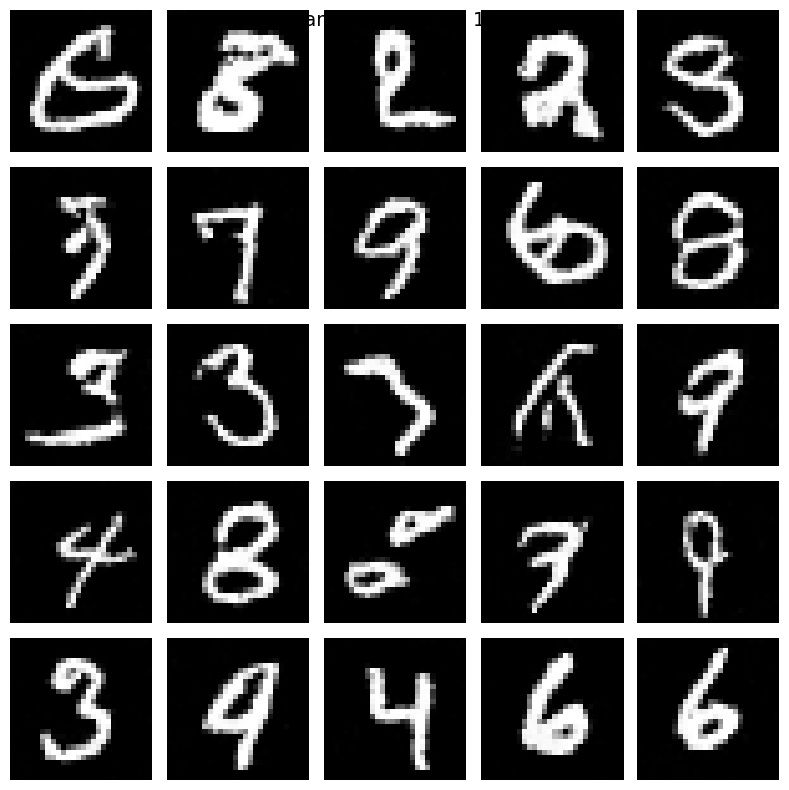

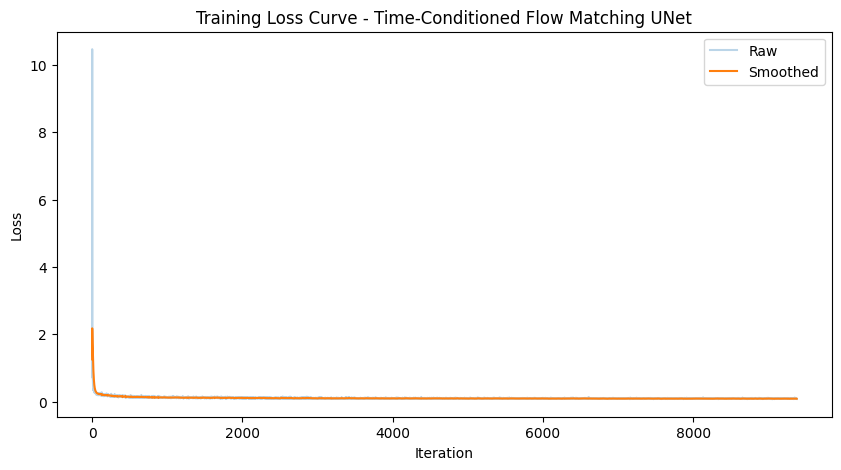

In [19]:
# Sampling from the UNet
# ===== your code here! ====

batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 10
num_ts = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

model = TimeConditionalUNet(in_channels = 1, num_classes = 10, num_hiddens = hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

train_losses = []
epochs = [1, 5, 10]

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for i, (images, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        x = images.to(device)

        loss = time_fm_forward(model, x, num_ts)
        item = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(item)
        epoch_losses.append(item)

    scheduler.step()

    epoch_avg = sum(epoch_losses) / len(epoch_losses)
    print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {epoch_avg:.4f}')

    if (epoch + 1) in epochs:
        print(f'\n--- Sampling at Epoch {epoch + 1} ---')
        fig = visualize_samples(model, num_samples=25, num_ts=num_ts, seed=42)
        plt.suptitle(f'Samples at Epoch {epoch + 1}', fontsize=14)
        plt.savefig(f'fm_samples_epoch_{epoch + 1}.png', dpi=150, bbox_inches='tight')
        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, alpha=0.3, label='Raw')

def smooth(values, weight=0.9):
    smoothed_version = []
    last = values[0]
    for v in values:
        temp = 1 - weight

        smoothed_val = last * weight + (temp) * v
        smoothed_version.append(smoothed_val)

        last = smoothed_val

    return smoothed_version

plt.plot(smooth(train_losses), label='Smoothed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Time-Conditioned Flow Matching UNet')

plt.legend()
plt.savefig('fm_training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====

# Part 2.4: Implementing a Class-conditioned UNet

In [20]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====

        D = num_hiddens

        self.conv_in = ConvBlock(in_channels, D)
        self.down1 = DownBlock(D, D)
        self.down2 = DownBlock(D, D)

        self.flatten = Flatten()
        self.unflatten = Unflatten(D)

        self.up1 = UpBlock(D * 2, D)
        self.up2 = UpBlock(D * 2, D)
        self.conv_out = ConvBlock(D * 2, D)

        self.final = nn.Conv2d(D + in_channels, in_channels, kernel_size = 3, stride = 1, padding = 1)

        self.fc1_t = FCBlock(1, D)
        self.fc2_t = FCBlock(1, D)

        self.fc1_c = FCBlock(num_classes, D)
        self.fc2_c = FCBlock(num_classes, D)

        self.num_classes = num_classes

        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====

        batch_size = x.shape[0]
        device = x.device

        t = t.view(-1, 1)

        c_onehot = torch.nn.functional.one_hot(c, num_classes=self.num_classes).float()

        if mask is not None:
            mask = mask.view(-1, 1).float()
            c_onehot = c_onehot * mask

        t1 = self.fc1_t(t)
        t2 = self.fc2_t(t)

        c1 = self.fc1_c(c_onehot)
        c2 = self.fc2_c(c_onehot)

        t1 = t1.view(batch_size, -1, 1, 1)
        t2 = t2.view(batch_size, -1, 1, 1)
        c1 = c1.view(batch_size, -1, 1, 1)
        c2 = c2.view(batch_size, -1, 1, 1)

        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x4 = self.flatten(x3)
        x5 = self.unflatten(x4)

        x5 = c1 * x5 * t1

        x6 = self.up1(torch.cat([x5, x3], dim = 1))

        x6 = c2 * x6 * t2

        x7 = self.up2(torch.cat([x6, x2], dim = 1))
        x8 = self.conv_out(torch.cat([x7, x1], dim = 1))

        out = self.final(torch.cat([x8, x], dim = 1))

        return out

        # ===== end of code ====

In [21]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====
    curr = x_1.device
    batch_size = x_1.shape[0]

    t = torch.rand(batch_size, device = curr)

    x = torch.randn_like(x_1)

    t_broadcast = t.view(batch_size, 1, 1, 1)
    x_time = (1 - t_broadcast) * x + t_broadcast * x_1

    u_target = x_1 - x
    mask = (torch.rand(batch_size, device = curr) > p_uncond).long()

    pred = unet(x_time, c, t, mask)
    loss = nn.functional.mse_loss(pred, u_target)

    return loss

    # ===== end of code ====

In [22]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # ===== your code here! ====

    torch.manual_seed(seed)

    curr = next(unet.parameters()).device
    H, W = img_wh
    batch_size = c.shape[0]

    x_time = torch.randn(batch_size, 1, H, W, device = curr)

    temp = 1.0 / num_ts

    for i in range(num_ts):
        t = torch.full((batch_size,), i / num_ts, device = curr)

        mask_cond = torch.ones(batch_size, device = curr, dtype = torch.long)
        mask_uncond = torch.zeros(batch_size, device = curr, dtype = torch.long)

        u_cond = unet(x_time, c, t, mask_cond)
        u_uncond = unet(x_time, c, t, mask_uncond)

        diff = u_cond - u_uncond

        u_guided = u_uncond + guidance_scale * diff

        x_time = x_time + temp * u_guided

    return x_time

    # ===== end of code ====

In [23]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

Epoch 1/20: 100%|██████████| 938/938 [00:18<00:00, 50.70it/s]


Epoch 1/20, Avg Loss: 0.1766, LR: 0.008913


Epoch 2/20: 100%|██████████| 938/938 [00:18<00:00, 51.40it/s]


Epoch 2/20, Avg Loss: 0.1129, LR: 0.007943


Epoch 3/20: 100%|██████████| 938/938 [00:18<00:00, 51.50it/s]


Epoch 3/20, Avg Loss: 0.1017, LR: 0.007079


Epoch 4/20: 100%|██████████| 938/938 [00:18<00:00, 51.72it/s]


Epoch 4/20, Avg Loss: 0.0971, LR: 0.006310


Epoch 5/20: 100%|██████████| 938/938 [00:18<00:00, 51.54it/s]


Epoch 5/20, Avg Loss: 0.0934, LR: 0.005623


Epoch 6/20: 100%|██████████| 938/938 [00:18<00:00, 51.80it/s]


Epoch 6/20, Avg Loss: 0.0915, LR: 0.005012


Epoch 7/20: 100%|██████████| 938/938 [00:18<00:00, 51.95it/s]


Epoch 7/20, Avg Loss: 0.0893, LR: 0.004467


Epoch 8/20: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]


Epoch 8/20, Avg Loss: 0.0883, LR: 0.003981


Epoch 9/20: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]


Epoch 9/20, Avg Loss: 0.0871, LR: 0.003548


Epoch 10/20: 100%|██████████| 938/938 [00:17<00:00, 52.30it/s]


Epoch 10/20, Avg Loss: 0.0861, LR: 0.003162


Epoch 11/20: 100%|██████████| 938/938 [00:18<00:00, 51.66it/s]


Epoch 11/20, Avg Loss: 0.0852, LR: 0.002818


Epoch 12/20: 100%|██████████| 938/938 [00:18<00:00, 52.08it/s]


Epoch 12/20, Avg Loss: 0.0840, LR: 0.002512


Epoch 13/20: 100%|██████████| 938/938 [00:17<00:00, 52.74it/s]


Epoch 13/20, Avg Loss: 0.0841, LR: 0.002239


Epoch 14/20: 100%|██████████| 938/938 [00:17<00:00, 52.55it/s]


Epoch 14/20, Avg Loss: 0.0837, LR: 0.001995


Epoch 15/20: 100%|██████████| 938/938 [00:17<00:00, 52.35it/s]


Epoch 15/20, Avg Loss: 0.0826, LR: 0.001778


Epoch 16/20: 100%|██████████| 938/938 [00:18<00:00, 51.88it/s]


Epoch 16/20, Avg Loss: 0.0818, LR: 0.001585


Epoch 17/20: 100%|██████████| 938/938 [00:17<00:00, 52.21it/s]


Epoch 17/20, Avg Loss: 0.0814, LR: 0.001413


Epoch 18/20: 100%|██████████| 938/938 [00:18<00:00, 51.65it/s]


Epoch 18/20, Avg Loss: 0.0814, LR: 0.001259


Epoch 19/20: 100%|██████████| 938/938 [00:18<00:00, 51.37it/s]


Epoch 19/20, Avg Loss: 0.0809, LR: 0.001122


Epoch 20/20: 100%|██████████| 938/938 [00:17<00:00, 52.12it/s]


Epoch 20/20, Avg Loss: 0.0806, LR: 0.001000


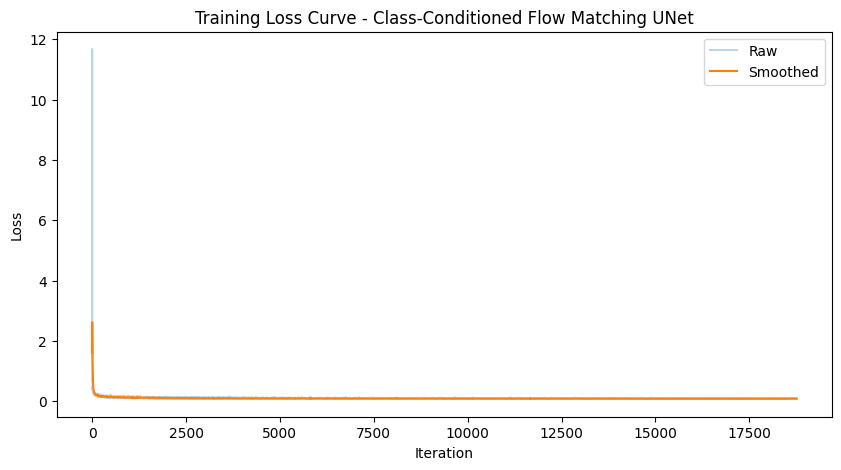

In [24]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 20
num_ts = 300
p_uncond = 0.1
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle =False)

model = ClassConditionalUNet(in_channels = 1, num_classes = num_classes, num_hiddens = hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        x = images.to(device)
        c = labels.to(device)

        loss = class_fm_forward(model, x, c, p_uncond, num_ts)
        item = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(item)
        epoch_losses.append(item)

    scheduler.step()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, alpha=0.3, label='Raw')

def smooth(values, weight=0.9):
    smoothed_version = []
    last = values[0]
    for v in values:
        temp = 1 - weight

        smoothed_val = last * weight + (temp) * v
        smoothed_version.append(smoothed_val)

        last = smoothed_val

    return smoothed_version

plt.plot(smooth(train_losses), label='Smoothed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Class-Conditioned Flow Matching UNet')

plt.legend()
plt.savefig('class_fm_training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====

# Part 2.6: Sampling from the Class-conditioned UNet

In [25]:
def visualize_class_samples(model, num_ts = 300, guidance_scale = 5.0, seed = 42):
    model.eval()
    curr = next(model.parameters()).device

    num_classes = 10
    num_instances = 4

    c = torch.arange(num_classes).repeat_interleave(num_instances).to(curr)

    wide = 28

    samples = class_fm_sample(
        model,
        c = c,
        img_wh = (wide, wide),
        num_ts = num_ts,
        guidance_scale = guidance_scale,
        seed = seed
    )

    fig, axes = plt.subplots(num_instances, num_classes, figsize = (12, 5))

    for i in range(num_instances):
        for j in range(num_classes):
            idx = j * num_instances + i
            img = samples[idx].cpu().squeeze()
            img = torch.clamp(img, 0, 1)
            axes[i, j].imshow(img, cmap = 'gray')
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(str(j), fontsize=12)

    plt.tight_layout()

    return fig


Epoch 1/10: 100%|██████████| 938/938 [00:17<00:00, 52.18it/s]


Epoch 1/10, Avg Loss: 0.1764

--- Sampling at Epoch 1 ---


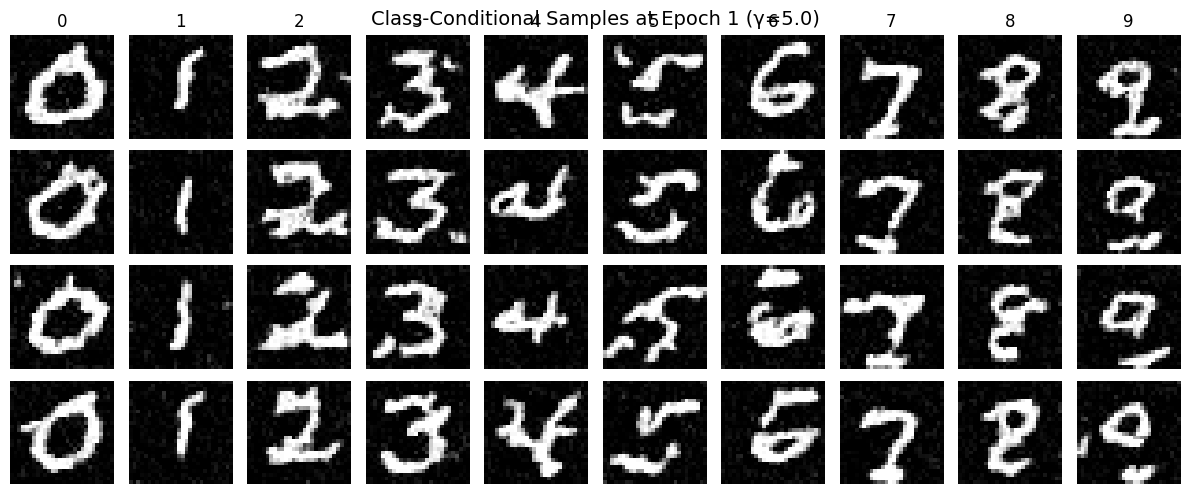

Epoch 2/10: 100%|██████████| 938/938 [00:18<00:00, 51.30it/s]


Epoch 2/10, Avg Loss: 0.1149


Epoch 3/10: 100%|██████████| 938/938 [00:18<00:00, 51.36it/s]


Epoch 3/10, Avg Loss: 0.1029


Epoch 4/10: 100%|██████████| 938/938 [00:18<00:00, 51.30it/s]


Epoch 4/10, Avg Loss: 0.0975


Epoch 5/10: 100%|██████████| 938/938 [00:18<00:00, 51.38it/s]


Epoch 5/10, Avg Loss: 0.0931

--- Sampling at Epoch 5 ---


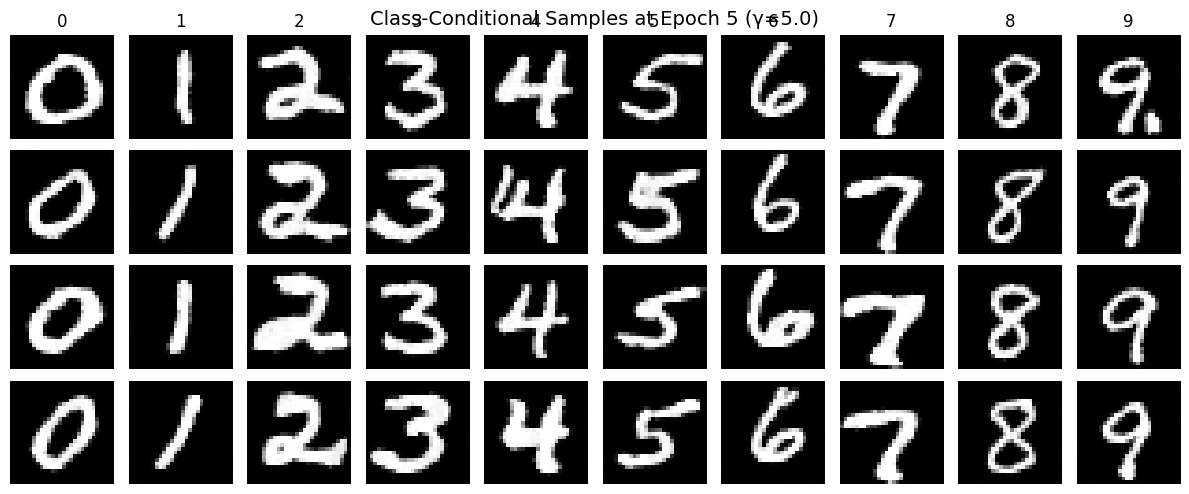

Epoch 6/10: 100%|██████████| 938/938 [00:18<00:00, 52.02it/s]


Epoch 6/10, Avg Loss: 0.0907


Epoch 7/10: 100%|██████████| 938/938 [00:18<00:00, 51.92it/s]


Epoch 7/10, Avg Loss: 0.0885


Epoch 8/10: 100%|██████████| 938/938 [00:18<00:00, 51.34it/s]


Epoch 8/10, Avg Loss: 0.0873


Epoch 9/10: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]


Epoch 9/10, Avg Loss: 0.0858


Epoch 10/10: 100%|██████████| 938/938 [00:17<00:00, 52.51it/s]


Epoch 10/10, Avg Loss: 0.0851

--- Sampling at Epoch 10 ---


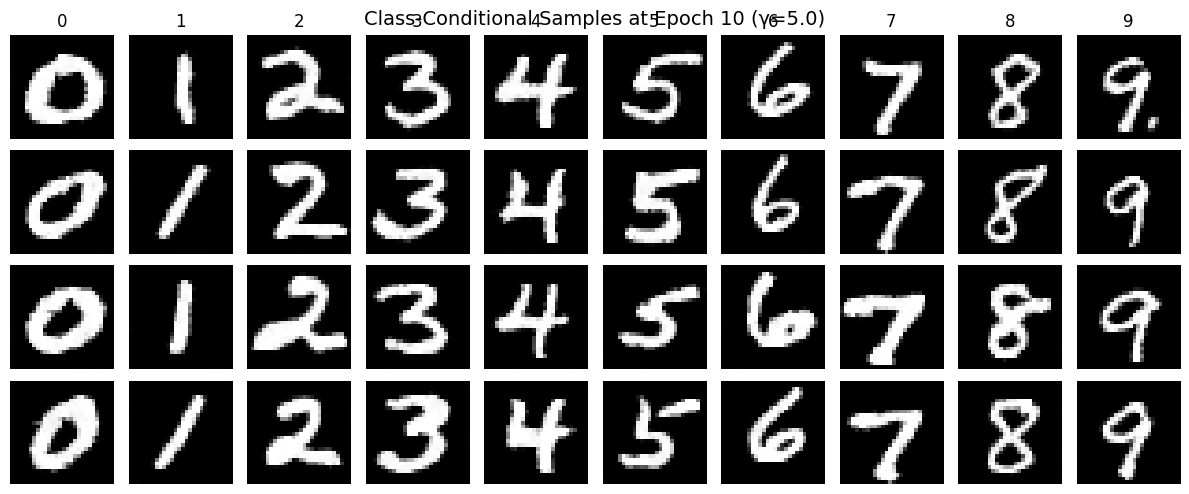

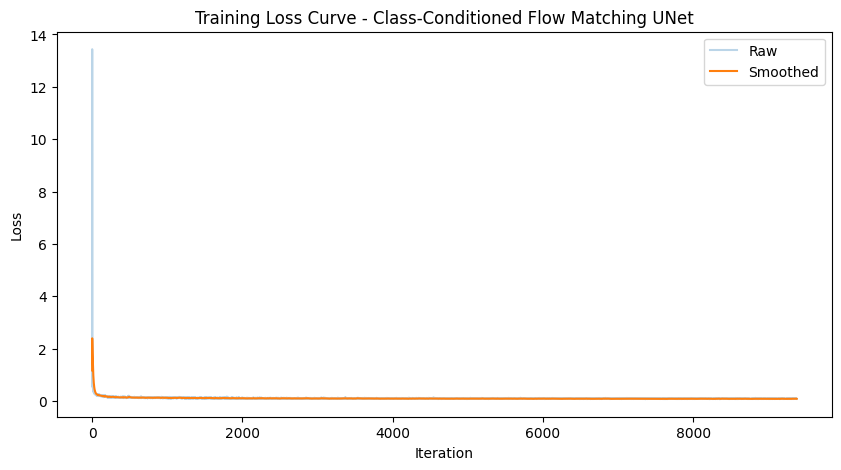

In [26]:
# Sampling from the UNet
# ===== your code here! ====

batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 10
num_ts = 300
p_uncond = 0.1
num_classes = 10
guidance_scale = 5.0

curr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

model = ClassConditionalUNet(in_channels = 1, num_classes = num_classes, num_hiddens = hidden_dim).to(curr)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

gamma = 0.1 ** (1.0 / num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)

train_losses = []
epochs = [1, 5, 10]

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):

        x = images.to(curr)
        c = labels.to(curr)

        loss = class_fm_forward(model, x, c, p_uncond, num_ts)
        item = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(item)
        epoch_losses.append(item)

    scheduler.step()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}')

    if (epoch + 1) in epochs:
        print(f'\n--- Sampling at Epoch {epoch + 1} ---')
        fig = visualize_class_samples(model, num_ts=num_ts, guidance_scale=guidance_scale, seed=42)

        plt.suptitle(f'Class-Conditional Samples at Epoch {epoch + 1} (γ={guidance_scale})', fontsize=14)
        plt.savefig(f'class_fm_samples_epoch_{epoch + 1}.png', dpi=150, bbox_inches='tight')
        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, alpha=0.3, label='Raw')

def smooth(values, weight=0.9):
    smoothed_version = []
    last = values[0]
    for v in values:
        temp = 1 - weight

        smoothed_val = last * weight + (temp) * v
        smoothed_version.append(smoothed_val)

        last = smoothed_val

    return smoothed_version

plt.plot(smooth(train_losses), label='Smoothed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve - Class-Conditioned Flow Matching UNet')
plt.legend()
plt.savefig('class_fm_training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== end of code ====